# Map Matching Project - Phase 1
<div style="text-align: center">
<h1 style = "color: red"> Sharif University Of Technology</h1>
<h2 style = "color: green"> DR. Mahdieh Soleymani | DR. MohammadHossein Rohban </h2>
<h3 style = "color: cyan"> Head of Project: AmirHossein Razlighi <h3>
<h3 style = "color: cyan"> Designed By: AmirHossein Razlighi - Hamidreza Yaghoubi - Alireza Heidari - Reza Vahidi Majd - Parham Rezaei<h3>
<h3 style = "color: cyan"> Documents Designed by: Mohammad Moshtaghi Far<h3>
<h4 style = "color: white"> Ask your questions via quera</h4>
<h5> Save your file with format: STUDENT NUMBER_Phase1.ipynb or .zip </h5>
</div>

Setting up the environment

In [ ]:
# %pip install pyrosm keplergl haversine pandas numpy

In [1]:
import datetime
import numpy as np
import pandas as pd
import pyrosm
import random
import ssl
import time
import keplergl
from pyrosm import OSM, get_data
import math
import matplotlib.pyplot as plt

In [ ]:
# If you are using colab, you need to run this cell
# from google.colab import output
# output.enable_custom_widget_manager()

## Introduction
In this phase of project, you are going to implement a *denoising algorithm*. In many cases, when an application is dealing with _user GPS location_, in many urban areas and the places with tall towers, the GPS signal gets too noisy! This is the reason of why when you open "google maps", you see your current location with a blue circle around it. The radius of this circle shows the accuracy of your location. Sometimes, this radius is around 10m and in other areas, it goes in scale of km, making the GPS location totally unstable and unreliable! This amount of noise makes it impossible to use the data for any kind of analysis. In "ride hailing" applications like Uber, many of functionalities rely on the accuracy of GPS data. E.g. ETA estimation (Estimated time of arrival) is highly dependent on the accuracy of GPS data. In this phase, you are going to implement a denoising algorithm to make the GPS data more reliable. You will use your kowledge of Hidden Markov Models to implement this algorithm.

<div style="text-align: center">
<img src="./Images/blue_dot.jpg" height="500" width="auto" /> </br>
(Sample of GPS data with blue dot)
</div>

# Loading Pasdaran streets dataset

In this section, you will load a dataset that is prepared for you. The dataset contains some GPS locations (nodes) from Pasdaran Streets and also another dataset which contains the "streets" in Pasdaran area. By "street" we mean a pair of nodes, representing two end-points of a street in the map. These datasets are in `Data/` folder with names `pasdaran_streets.csv` and `pasdaran_nodes.csv`.

In [2]:
# Load the data
pasdaran_streets = pd.read_csv('pasdaran_streets.csv')
pasdaran_nodes = pd.read_csv('pasdaran_nodes.csv')

In [3]:
pasdaran_streets.head()

,street_id,u,v,length,oneway,u_lat,u_lon,v_lat,v_lon
0,5003747,423833948,423793584,90.570,no,35.772419,51.465652,35.771748,51.465084
1,17099043,177540293,423832815,296.273,yes,35.771034,51.464462,35.772175,51.461494
2,787945693,4429684144,423832815,62.573,no,35.772636,51.461891,35.772175,51.461494
3,687277053,177540293,423793585,97.898,no,35.771034,51.464462,35.770317,51.463833
4,36333153,9339973930,423793585,296.275,yes,35.771458,51.460865,35.770317,51.463833


In [4]:
pasdaran_nodes.head()

,id,lat,lon
0,423833948,35.772419,51.465652
1,423793584,35.771748,51.465084
2,177536927,35.776230,51.465034
3,177540293,35.771034,51.464462
4,423832815,35.772175,51.461494


In [5]:
# Visualize pasdaran_streets using kepler
map = keplergl.KeplerGl()
map.add_data(name='pasdaran_nodes', data=pasdaran_nodes)
map


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'pasdaran_nodes': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, …

# Creating dataset for trip

As you understood, until now, we loaded 2 datasets, `pasdaran_nodes` and `pasdaran_streets`. Now, we should create a dataset from these, such that we can use it for our trip. Each item in this dataset is called a `ride`. We will explain more as we go on.

First, we should create a **trip** for a driver. For this sake, we should choose 2 random points in our map as the source and destination of the trip. Now, we should find the streets that connect these 2 points. Each street has a length. You should find the shortest path between these 2 points (source and destination) which are in the `pasdaran_streets`. Note that this path should be the **shortest path** meaning that the sum of the lengths of streets should be minimum.

**NOTE**: You cannot use any library for finding the shortest path. You should implement it yourself, from scratch. Feel free to use any algorithm and heuristic that you want. Be creative!

**NOTE**: Be aware of "length of streets" and whether or not they are "one_way"!

In [6]:
import heapq

class min_heap:
    def __init__(self):
        self._queue = []
        self._index = 0
    
    def push(self, item, priority):
        heapq.heappush(self._queue, (priority, self._index, item))
        self._index += 1

    def pop(self):
        return heapq.heappop(self._queue)[-1]
        
    
    def size(self):
        return len(self._queue)


def restore_path(start_node, end_node, pred):
    path = []
    cur = end_node
    while True:
        path.append(cur)
        if cur == start_node:
            break
        cur = pred[cur]
    path.reverse()
    return path
    

# TODO: You should implement this from scratch and you cannot use any library (such as networkx) for finding the shortest path.
# Dijkstra's algorithm
def find_shortest_path(start_node, end_node, graph):
    """
    Find the shortest path between two nodes in a graph.
    :param start_node: The start node
    :param end_node: The end node
    :param graph: The graph
    :return: The shortest path. It is a list of node_ids from start_node to end_node.
    Note that you use all of the data in "pasdaran_streets" dataset appropriately such as "street_length" and "one_way".
    """
    if isinstance(start_node, tuple):
        lat_1, lon_1 = start_node
        lat_2, lon_2 = end_node
        row = graph[((graph['u_lat'] == lat_1) & (graph['u_lon'] == lon_1))]
        if len(row) > 0:
            start_node = row['u'].values[0]
        else:
            row = graph[((graph['v_lat'] == lat_1) & (graph['v_lon'] == lon_1))]
            start_node = row['v'].values[0]
        
        row = graph[((graph['u_lat'] == lat_2) & (graph['u_lon'] == lon_2))]
        if len(row) > 0:
            end_node = row['u'].values[0]
        else:
            row = graph[((graph['v_lat'] == lat_2) & (graph['v_lon'] == lon_2))]
            end_node = row['v'].values[0]
    
    # Build the adjacency list
    adj = dict()
    for index, row in graph.iterrows():
        u = row['u']
        v = row['v']
        w = row['length']
        
        if u not in adj:
            adj[u] = set()
        if v not in adj:
            adj[v] = set()
        adj[u].add((v, w))
        adj[v].add((u, w))

    is_done = set()
    dist = {start_node: 0}
    pq = min_heap()
    pq.push(start_node, 0)
    pred = dict()

    while pq.size() > 0:
        u = pq.pop()
        is_done.add(u)
        if u == end_node:
            return restore_path(start_node, end_node, pred)
        for neighbor in adj[u]:
            v = neighbor[0]
            w = neighbor[1]
            if v in is_done:
                continue
            if v not in dist:
                dist[v] = float('inf')
            if dist[u] + w < dist[v]:
                dist[v] = dist[u] + w
                pred[v] = u
                pq.push(v, dist[v])
    return []

    

You should **upload** this cell (`find_shortest_path` function) as a .py file to quera. Your code will be verified if it is actually finding the shortest path and only if it's correct, you will get the grades of this section. Be sure that you put the approriate `import ...` statements at the first of your `.py` file. Remember, you **can not** use any library that does the "shortest path" for you. (like networkx) You should implement it yourself.

**Note**: You can add other functions and codes to above cell, but you code should have the `find_shortest_path` function with exactly same signature that we have provided. Your code will be tested with calling this function. So, using other functions is not a problem, but keep in mind that the main entry for your code when we test it is the `find_shortest_path` function. Nothing else!

In [7]:
# Create a trip: Choose 2 random points as start and end points and find the shortest path between them.
# A trip is a list of node_ids from start_node to end_node.
# TODO: Implement and print out a sample trip


# start_node = 4493669625
# end_node = 5667400227

# start_node = 1762129807 
# end_node = 4698536184

# start_node = 4696627039
# end_node = 423816012

start_node = 4403810840
end_node = 1707151218

# start_node = 423832815
# end_node = 177540293

# start_node = 177540293
# end_node = 423832815

# start_node = 423830747
# end_node = 4316456836

trip = find_shortest_path(start_node, end_node, pasdaran_streets)
print(trip)

[4403810840, 10286634512, 2170381752, 10286634511, 423816404, 4403810838, 423816405, 9357300681, 4692533034, 423816406, 4695837565, 4683382443, 4695737210, 4695737204, 7606688922, 4695737212, 423815687, 1762129786, 1762129788, 1762129779, 423816039, 4379726018, 4695666786, 4379726017, 806589535, 806589358, 4695818010, 4695818011, 423832591, 4879764419, 10882786110, 1864300723, 10882786107, 423832805, 423793656, 423832793, 423793595, 4379726019, 30772620, 4379726029, 429412485, 4429680695, 423793594, 423832802, 423793593, 423832796, 9339973930, 4429680702, 423832815, 4429684144, 423793591, 423832946, 423832945, 2106802326, 423832944, 4695969112, 423832943, 4482481112, 423832942, 423832817, 423832941, 1707151179, 423833040, 4657965378, 423833041, 423833042, 4696632873, 4698562496, 6089414139, 6089414123, 6089414124, 6089414125, 6089414130, 6089414131, 6089414132, 6089414133, 6089414140, 1707151218]


Visualize the sampled trip (in the previous cell) on the map. Use `kepler` library for this purpose. Notice that you use keplers "timestep" attributes to create a timeline, so you can see the trip's process from _start\_node_ to _end\_node_. (You can see an output sample in the next cell)

In [8]:
#TODO: Visualize the sampled trip using kepler
trip_df = pd.DataFrame({'id': [], 'lat': [], 'lon': [], 'time': []})
for i in range(len(trip)):
    row = pasdaran_nodes[pasdaran_nodes['id'] == trip[i]]
    new_data = pd.DataFrame({'id': trip[i], 'lat': row['lat'], 'lon': row['lon'], 'time': i})
    trip_df = pd.concat([trip_df, new_data], ignore_index=True)

tmp_map = keplergl.KeplerGl()
tmp_map.add_data(data=trip_df, name='trip_nodes')

tmp_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'trip_nodes': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, …

Now, we are going to get the points in the middle of the streets. Before, we only had the intersections of the streets(start and end nodes of a section). But we know in real life, we get gps locations also in between and not necessarily in the intersections. So, we should add these points to our data. We call every entity of this type as `Ride`. A ride is defined by 3 parameters:
1. `ride_speed`: The speed of the ride which driver is driving with. We assume that the driver is driving with a constant speed.
2. `driver_gps_time`: The time interval that the driver sends his/her gps location to the server. (e.g. every 5 seconds)
3. `trip`: The specific trip that the driver is driving in. (we created this in the previous cells)

Now, you should define a function that gets these parameters and returns the locations (lat/longs) in the ride regarding the given parameters.

In [9]:
import builtins as buin

R = 6371000 

# distance of two points
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = buin.map(math.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = R * c

    return distance


def calculate_initial_bearing(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = buin.map(math.radians, [lat1, lon1, lat2, lon2])

    dlon = lon2 - lon1

    # Calculate initial bearing
    x = math.sin(dlon) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1) * math.cos(lat2) * math.cos(dlon))
    initial_bearing = math.atan2(x, y)

    initial_bearing = (math.degrees(initial_bearing) + 360) % 360

    return initial_bearing


def move_towards(lat1, lon1, lat2, lon2, distance):
    # Calculate initial bearing
    initial_bearing = calculate_initial_bearing(lat1, lon1, lat2, lon2)

    # Move towards the destination with the specified distance
    lat2, lon2 = move_towards_initial(lat1, lon1, initial_bearing, distance)

    return lat2, lon2


def move_towards_initial(lat1, lon1, brng, distance):
    lat1, lon1, brng = buin.map(math.radians, [lat1, lon1, brng])

    lat2 = math.asin(math.sin(lat1) * math.cos(distance/R) + math.cos(lat1) * math.sin(distance/R) * math.cos(brng))

    lon2 = lon1 + math.atan2(math.sin(brng) * math.sin(distance/R) * math.cos(lat1),
                             math.cos(distance/R) - math.sin(lat1) * math.sin(lat2))

    lat2, lon2 = buin.map(math.degrees, [lat2, lon2])

    return lat2, lon2

In [10]:
#TODO
# output.  KeplerGL()
# input. rides: a list of rides,   use_timesteps: use timestep on the corresponding ride,      use_animation: use animation on the corresponding ride
def visualize_a_ride(rides, use_timesteps, use_animations):
    map = keplergl.KeplerGl()
    for i in range(len(rides)):
        ride = rides[i]
        use_timestep = use_timesteps[i]
        use_animation = use_animations[i]
        df = pd.DataFrame(ride, columns=['lat', 'lon'])
        timestep_col = [i for i in range(len(df))]
        if use_timestep:
            df['timestep'] = timestep_col
        # TODO: implement animation
        map.add_data(name=f'nodes_{i}', data=df)
    return map        
        

# return [[lat_i, lon_i], ...]
def get_ride(ride_speed, ride_gps_time, trip):
    # (node_id, lat, lon)
    trip_data = []
    for node in trip:
        row = pasdaran_nodes[pasdaran_nodes['id'] == node]
        trip_data.append((node, row['lat'], row['lon']))
    
    # [length]
    streets_trip = []
    for i in range(len(trip_data) - 1):
        row = pasdaran_streets[((pasdaran_streets['u'] == trip_data[i][0]) & (pasdaran_streets['v'] == trip_data[i + 1][0])) | ((pasdaran_streets['v'] == trip_data[i][0]) & (pasdaran_streets['u'] == trip_data[i + 1][0]))]
        streets_trip.append(row['length'].values[0])
    
    delta_x = ride_speed * ride_gps_time
    ride = []
    ride.append([trip_data[0][1], trip_data[0][2]])
    i = 0
    cur_pos = [trip_data[0][1], trip_data[0][2]]
    while i < len(trip_data) - 1:
        dx = delta_x
        # distance of current_pos to the next node
        lngth = haversine(cur_pos[0], cur_pos[1], trip_data[i + 1][1], trip_data[i + 1][2])
        while dx >= lngth:
            i += 1
            if i == len(trip_data) - 1:
                break
            dx -= lngth
            cur_pos = [trip_data[i][1], trip_data[i][2]]
            lngth = streets_trip[i]
        if i == len(trip_data) - 1:
            break
        new_lat, new_lon = move_towards(cur_pos[0], cur_pos[1], trip_data[i + 1][1], trip_data[i + 1][2], dx)
        cur_pos = [new_lat, new_lon]
        ride.append([new_lat, new_lon])
    ride.append([trip_data[-1][1], trip_data[-1][2]])

    return ride


See a sample ride, printed out.

In [11]:
#TODO
ride_speed = 10
ride_gps_time = 5
ride = get_ride(ride_speed=ride_speed, ride_gps_time=ride_gps_time, trip=trip)

C:\Users\masou\AppData\Local\Temp\ipykernel_11212\534153284.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lat1, lon1, lat2, lon2 = buin.map(math.radians, [lat1, lon1, lat2, lon2])
C:\Users\masou\AppData\Local\Temp\ipykernel_11212\534153284.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lat1, lon1, lat2, lon2 = buin.map(math.radians, [lat1, lon1, lat2, lon2])
C:\Users\masou\AppData\Local\Temp\ipykernel_11212\534153284.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lat1, lon1, brng = buin.map(math.radians, [lat1, lon1, brng])


Visualize the sample ride on the map using `kepler` library. You should define an animation based on the order of the points in the ride, so you can play the animation in the visualization and see the ride!

## Explanation:
We can add the `time` from the upper left window to the filters so that we can see the ride as an animation

In [12]:
#TODO: Visualize the sampled ride using kepler
map = visualize_a_ride([ride], [True], [False])
map


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'nodes_0': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…

Now, to complete our dataset, we need to put some random noise on the gps locations. For this sake, we easily add some random noise to the lat/longs of a created `ride`. You should define a function that gets a `ride` and adds some random noise to the lat/longs of the ride. Your function should take in 2 parameters: _ride_ and _gps\_noise\_radius_ which is the radius of the circle that you want to add noise to the gps locations. (e.g. 10 meters). The gps noise in assumed to be a normal distribution. So, assume `standard deviation` of the noise to be `gps_noise_radius`.

In [13]:
# put a random noise on each (lat, lon) location to simulate the GPS noise (suppoes GPS radius is 3 - 8 meters)
# TODO
# Print out a sample
def add_noise(ride, gps_noise_radius, method, speed=0):
    noisy_ride = [row.copy() for row in ride]
    N = len(ride)
    if method == 'gaussian':
        for i in range(N):
            rnd_radius = np.random.normal(0, gps_noise_radius)
            rnd_brng = np.random.uniform(0, 360)
            new_lat, new_lon = move_towards_initial(ride[i][0], ride[i][1], rnd_brng, rnd_radius)
            noisy_ride[i] = [new_lat, new_lon]
        return noisy_ride
    elif method == 'uniform':
        for i in range(N):
            rnd_radius = np.random.uniform(0, gps_noise_radius)
            rnd_brng = np.random.uniform(0, 360)
            new_lat, new_lon = move_towards_initial(ride[i][0], ride[i][1], rnd_brng, rnd_radius)
            noisy_ride[i] = [new_lat, new_lon]
        return noisy_ride
    elif method == 'speed_gaussian':
        for i in range(N):
            rnd_radius = np.random.uniform(0, gps_noise_radius) * np.sqrt(speed)
            rnd_brng = np.random.uniform(0, 360)
            new_lat, new_lon = move_towards_initial(ride[i][0], ride[i][1], rnd_brng, rnd_radius)
            noisy_ride[i] = [new_lat, new_lon]
        return noisy_ride
    

### Different noise models
Experiment adding noise to rides using different models (PDFs) of noise. For example, you can use a uniform distribution for noise. Or you can use a normal distribution for noise. Or you can use a mixture of different distributions. You can also use a distribution that is dependent on the speed of the ride.
1. Visualize each noise model (PDF) on a plot. (You can use `matplotlib` library for this purpose)
2. Visualize the rides with different noise models on the map. (You can use `kepler` library for this purpose)
3. Compare the results of different noise models. Which one is more descriptive of the real world? Why?
4. Choose one model that you find appropriate for training your HMM on it. We will use that model for the rest of the project.

In [14]:
#TODO: Experimenting with different GPS noise radiuses
gps_noise_radiuses = [8, 40, 100]
gaussian_noisy_ride_1 = add_noise(ride, gps_noise_radiuses[0], 'gaussian')
gaussian_noisy_map_1 = visualize_a_ride([ride, gaussian_noisy_ride_1], [True, False], [False, False])

gaussian_noisy_ride_2 = add_noise(ride, gps_noise_radiuses[1], 'gaussian')
gaussian_noisy_map_2 = visualize_a_ride([ride, gaussian_noisy_ride_2], [True, False], [False, False])

gaussian_noisy_ride_3 = add_noise(ride, gps_noise_radiuses[2], 'gaussian')
gaussian_noisy_map_3 = visualize_a_ride([ride, gaussian_noisy_ride_3], [True, False], [False, False])

uniform_noisy_ride_1 = add_noise(ride, gps_noise_radiuses[0], 'uniform')
uniform_noisy_map_1 = visualize_a_ride([ride, uniform_noisy_ride_1], [True, False], [False, False])

uniform_noisy_ride_2 = add_noise(ride, gps_noise_radiuses[1], 'uniform')
uniform_noisy_map_2 = visualize_a_ride([ride, uniform_noisy_ride_2], [True, False], [False, False])

speed_gaussian_noisy_ride_1 = add_noise(ride, gps_noise_radiuses[0], 'speed_gaussian', speed=10)
speed_gaussian_noisy_map_1 = visualize_a_ride([ride, speed_gaussian_noisy_ride_1], [True, False], [False, False])

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


C:\Users\masou\AppData\Local\Temp\ipykernel_11212\534153284.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lat1, lon1, brng = buin.map(math.radians, [lat1, lon1, brng])
C:\Users\masou\AppData\Local\Temp\ipykernel_11212\534153284.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lat1, lon1, brng = buin.map(math.radians, [lat1, lon1, brng])
C:\Users\masou\AppData\Local\Temp\ipykernel_11212\534153284.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lat1, lon1, brng = buin.map(math.radians, [lat1, lon1, brng])
C:\Users\masou\AppData\Local\Temp\ipykernel_11212\534153284.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future.

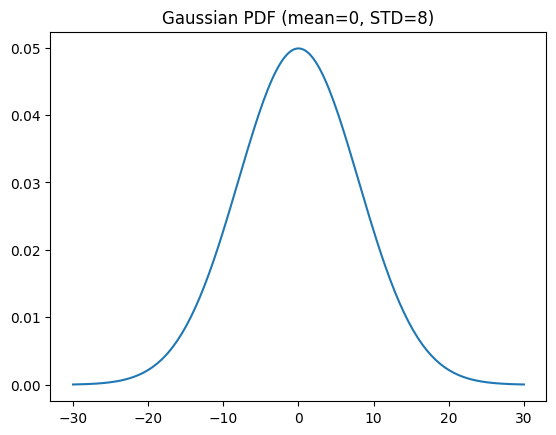

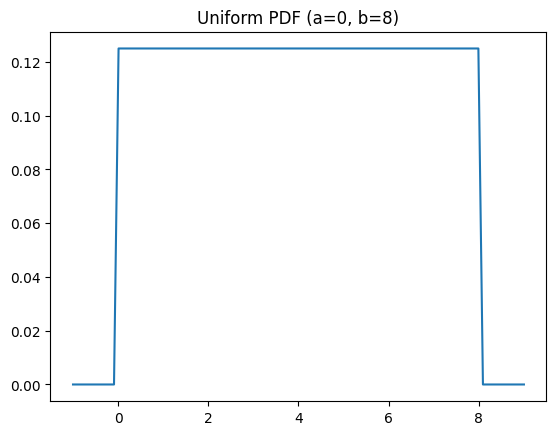

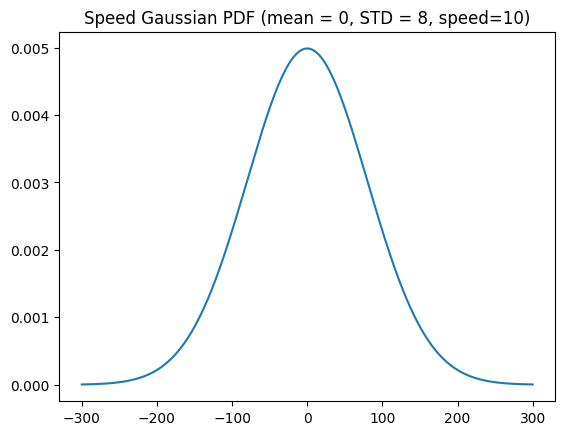

In [15]:
#TODO: Visualize the noise models using matplotlib
def gaussian_pdf(x, mean, std):
    return np.exp(-((x - mean) ** 2) / (2 * (std ** 2))) / (std * np.sqrt(2 * np.pi))

linspace_gaussian_1 = np.linspace(-30, 30, 200)
y_gaussian_1 = []
for i in range(len(linspace_gaussian_1)):
    y_gaussian_1.append(gaussian_pdf(linspace_gaussian_1[i], 0, gps_noise_radiuses[0]))
plt.plot(linspace_gaussian_1, y_gaussian_1)
plt.title(f'Gaussian PDF (mean=0, STD={gps_noise_radiuses[0]})')
plt.show()

linspace_uniform_1 = np.linspace(-1, gps_noise_radiuses[0] + 1, 100)
y_uniform_1 = []
for i in range(len(linspace_uniform_1)):
    x = linspace_uniform_1[i]
    if x < 0 or x > gps_noise_radiuses[0]:
        y_uniform_1.append(0)
    else:
        y_uniform_1.append(1 / gps_noise_radiuses[0])
plt.plot(linspace_uniform_1, y_uniform_1)
plt.title(f'Uniform PDF (a=0, b={gps_noise_radiuses[0]})')
plt.show()

linspace_speed_gaussian_1 = np.linspace(-300, 300, 10000)
y_speed_gaussian_1 = []
for i in range(len(linspace_speed_gaussian_1)):
    y_speed_gaussian_1.append(gaussian_pdf(linspace_speed_gaussian_1[i], 0, ride_speed * gps_noise_radiuses[0]))
plt.plot(linspace_speed_gaussian_1, y_speed_gaussian_1)
plt.title(f'Speed Gaussian PDF (mean = 0, STD = {gps_noise_radiuses[0]}, speed={ride_speed})')
plt.show()
        


In [16]:
#TODO: Visualize the noise models using kepler
print(f'Gaussian noise (STD: {gps_noise_radiuses[0]}):')
gaussian_noisy_map_1

Gaussian noise (STD: 8):


KeplerGl(data={'nodes_0': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…

In [35]:
print(f'Gaussian noise (STD: {gps_noise_radiuses[1]}):')
gaussian_noisy_map_2

Gaussian noise (STD: 40):


KeplerGl(data={'nodes_0': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…

In [36]:
print(f'Gaussian noise (STD: {gps_noise_radiuses[2]}):')
gaussian_noisy_map_3

Gaussian noise (STD: 100):


KeplerGl(data={'nodes_0': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…

In [17]:
print(f'Uniform noise ((0, {gps_noise_radiuses[0]}))')
uniform_noisy_map_1

Uniform noise ((0, 8))


KeplerGl(data={'nodes_0': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…

In [41]:
print(f'Uniform noise ((0, {gps_noise_radiuses[1]}))')
uniform_noisy_map_2

Uniform noise ((0, 40))


KeplerGl(data={'nodes_0': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…

In [18]:
print(f'Speed Gaussian Noise (mean=0, STD={gps_noise_radiuses[0]}, speed={ride_speed})')
speed_gaussian_noisy_map_1

Speed Gaussian Noise (mean=0, STD=8, speed=10)


KeplerGl(data={'nodes_0': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…

In [19]:
#TODO: Choose the best model (while you explain why you chose it)
rw_noisy_ride = speed_gaussian_noisy_ride_1
rw_noisy_map = speed_gaussian_noisy_map_1

**Explanation of my noise model:**

In the most real world phenomena, noise can be modeled by a gaussian random variable with zero mean. In this example, we know that as speed of the driver increases, the probability of incorrect GPS position increases. <br>
So a good way to model the driver's noise, is to use a gaussian random variable with mean:0, STD:(some constant) * f(speed)     (for some f(.))

Visualize a sample `ride` and its corresponding `noisy_ride` (using your selected noise model) on the map.

In [17]:
#TODO: Visualize using kepler
print(f'Gaussian noise multiplied by speed (mean=0, STD={gps_noise_radiuses[0]}, speed={ride_speed})')
speed_gaussian_noisy_map_1

Gaussian noise multiplied by speed (mean=0, STD=8, speed=10)


KeplerGl(data={'nodes_0': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…

Now, we create our dataset, We create 20 noisy_rides for each trip.

In [17]:
#TODO: create and store 20 noisy_rides as a dataset for our HMM to train on it and experiment with it
num_noisy_rides = 20
noisy_rides = [add_noise(ride, gps_noise_radiuses[0], 'speed_gaussian', speed=ride_speed) for i in range(num_noisy_rides)]

C:\Users\masou\AppData\Local\Temp\ipykernel_11212\534153284.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lat1, lon1, brng = buin.map(math.radians, [lat1, lon1, brng])


# HMM

In this section, we want to use the dataset that we created in the previous section to train an HMM model. We want to use HMM models to  **denoise** the gps locations of the rides. We assume that the gps locations of the rides are noisy and we want to denoise them using HMM models. The observations in each _timestamp_ are the observed noisy points in the dataset.

You should implement a class (or function) named HMM which gets the noisy observations and the `streets` of the map (of course, this is not noisy. we saw that as `pasdaran_streets` in the previous section). You should calculate the transition matrix and emission matrix of the HMM model. You should also implement the `viterbi` algorithm to find the most probable sequence of hidden states (which are the points in the streets) given the noisy observations. Finally, your implementation should be capable of returning the denoised gps locations of the rides. Note that how you define your features, and your states. Be creative!

In [18]:
#TODO: Implement helper functions for your calculations
from tqdm import tqdm

def cross_track_distance(lat_1, lon_1, lat_2, lon_2, lat_p, lon_p):
    delta_1_3 = haversine(lat_1, lon_1, lat_p, lon_p) / R
    theta_1_p = calculate_initial_bearing(lat_1, lon_1, lat_p, lon_p)
    theta_1_2 = calculate_initial_bearing(lat_1, lon_1, lat_2, lon_2)
    return abs(math.asin(math.sin(delta_1_3) * math.sin(math.radians(theta_1_p) - math.radians(theta_1_2))) * R)


def project_point_on_arc(lat_1, lon_1, lat_2, lon_2, lat_p, lon_p):
    len_1_2 = haversine(lat_1, lon_1, lat_2, lon_2) / R
    len_1_p = haversine(lat_1, lon_1, lat_p, lon_p) / R
    len_2_p = haversine(lat_2, lon_2, lat_p, lon_p) / R
    cos_p_1_2 = (math.cos(len_2_p) - math.cos(len_1_p) * math.cos(len_1_2)) / (math.sin(len_1_p) * math.sin(len_1_2))
    cos_p_2_1 = (math.cos(len_1_p) - math.cos(len_2_p) * math.cos(len_1_2)) / (math.sin(len_2_p) * math.sin(len_1_2))
    if cos_p_1_2 > 1:
        cos_p_1_2 = 1
    elif cos_p_1_2 < -1:
        cos_p_1_2 = -1
    if cos_p_2_1 > 1:
        cos_p_2_1 = 1
    elif cos_p_2_1 < -1:
        cos_p_2_1 = -1
    deg_p_1_2 = math.degrees(math.acos(cos_p_1_2))
    deg_p_2_1 = math.degrees(math.acos(cos_p_2_1))
    if deg_p_1_2 > 90:
        return lat_1, lon_1
    if deg_p_2_1 > 90:
        return lat_2, lon_2
    xt_dist = cross_track_distance(lat_1, lon_1, lat_2, lon_2, lat_p, lon_p)
    foo = haversine(lat_1, lon_1, lat_p, lon_p)
    bar = math.acos(math.cos(foo / R) / math.cos(xt_dist / R)) * R
    new_lat, new_lon = move_towards(lat_1, lon_1, lat_2, lon_2, bar)
    return new_lat, new_lon


def mean_haversine_distance(denoised_points, original_points):
    sum = 0.0
    for i in range(len(denoised_points)):
        sum += haversine(denoised_points.iloc[i]['lat'], denoised_points.iloc[i]['lon'], original_points.iloc[i]['lat'], original_points.iloc[i]['lon'])
    sum /= len(denoised_points)
    return sum


def MHD_list(denoised_points, original_points):
    sum = 0.0
    for i in range(len(denoised_points)):
        sum += haversine(denoised_points[i][0], denoised_points[i][1], original_points[i][0], original_points[i][1])
    sum /= len(denoised_points)
    return sum


def normalize(arr):
    s = np.sum(arr)
    for i in range(len(arr)):
        arr[i] /= s


# path: a list of node_id s
def find_path_length(path, graph):
    if len(path) < 2:
        # TODO: fix this
        return 200
        # print('bug in finding path-length')
    sum = 0.0
    for i in range(len(path) - 1):
        node_id_1 = path[i]
        node_id_2 = path[i + 1]
        row = graph[(((graph['u'] == node_id_1) & (graph['v'] == node_id_2)) | ((graph['v'] == node_id_1) & (graph['u'] == node_id_2)))]
        sum += row['length'].values[0]
    return sum




In [19]:
# Use Viterbi Algorithm to find the most probable set of points (denoised points)
sigma = 12.919
lamda = 1


# return [(lat_proj_i, lon_proj_i, street_index_i)]
def get_proj_points(lat, lon):
    k = 2
    foo = np.zeros(len(pasdaran_streets))
    for i in range(len(pasdaran_streets)):
        row = pasdaran_streets.iloc[i]
        proj_lat, proj_lon = project_point_on_arc(row['u_lat'], row['u_lon'], row['v_lat'], row['v_lon'], lat, lon)
        foo[i] = haversine(lat, lon, proj_lat, proj_lon)
    bar = np.argpartition(foo, k)[:k]
    bar = bar[np.argsort(foo[bar])]
    res = []
    for street_index in bar:
        lat_proj, lon_proj = project_point_on_arc(pasdaran_streets.iloc[street_index]['u_lat'], pasdaran_streets.iloc[street_index]['u_lon'], pasdaran_streets.iloc[street_index]['v_lat'], pasdaran_streets.iloc[street_index]['v_lon'], lat, lon)
        res.append((lat_proj, lon_proj, street_index))
    return res
    
    
# z: (lat, lon)
# x: (lat, lon, street_index)
def transition_prob(z, z_prime, x, x_prime):
    d_t = abs(haversine(z[0], z[1], z_prime[0], z_prime[1]) - route_distance(x, x_prime))
    # d_t = abs(haversine(z[0], z[1], z_prime[0], z_prime[1]) - haversine(x[0], x[1], x_prime[0], x_prime[1]))
    return lamda * np.exp(-lamda * d_t)


def emission_prob(z, p):
    return np.exp(-0.5 * (((haversine(z[0], z[1], p[0], p[1])) / sigma) ** 2)) / (sigma * np.sqrt(2 * np.pi))


# p: (lat, lon, street_index)
def route_distance(p1, p2):
    lat_1 = p1[0]
    lon_1 = p1[1]
    street_index_1 = p1[2]
    lat_2 = p2[0]
    lon_2 = p2[1]
    street_index_2 = p2[2]

    graph = pasdaran_streets.copy(deep=True)
    segment_1 = graph.iloc[street_index_1]
    segment_2 = graph.iloc[street_index_2]
    graph = pd.concat([graph, pd.DataFrame({'street_id': segment_1['street_id'], 'u': [-1], 'v': segment_1['u'], 'length': haversine(lat_1, lon_1, segment_1['u_lat'], segment_1['u_lon']), 'oneway': 'no', 'u_lat': lat_1, 'u_lon': lon_1, 'v_lat': segment_1['u_lat'], 'v_lon': segment_1['u_lon']})], ignore_index=True)
    graph = pd.concat([graph, pd.DataFrame({'street_id': segment_1['street_id'], 'u': [-1], 'v': segment_1['v'], 'length': haversine(lat_1, lon_1, segment_1['v_lat'], segment_1['v_lon']), 'oneway': 'no', 'u_lat': lat_1, 'u_lon': lon_1, 'v_lat': segment_1['v_lat'], 'v_lon': segment_1['v_lon']})], ignore_index=True)
    graph = pd.concat([graph, pd.DataFrame({'street_id': segment_2['street_id'], 'u': [-2], 'v': segment_2['u'], 'length': haversine(lat_2, lon_2, segment_2['u_lat'], segment_2['u_lon']), 'oneway': 'no', 'u_lat': lat_2, 'u_lon': lon_2, 'v_lat': segment_2['u_lat'], 'v_lon': segment_2['u_lon']})], ignore_index=True)
    graph = pd.concat([graph, pd.DataFrame({'street_id': segment_2['street_id'], 'u': [-2], 'v': segment_2['v'], 'length': haversine(lat_2, lon_2, segment_2['v_lat'], segment_2['v_lon']), 'oneway': 'no', 'u_lat': lat_2, 'u_lon': lon_2, 'v_lat': segment_2['v_lat'], 'v_lon': segment_2['v_lon']})], ignore_index=True)
    graph = graph.drop([street_index_1, street_index_2])
    graph.reset_index(inplace=True)
    sp = find_shortest_path(-1, -2, graph)
    path_length = find_path_length(sp, graph)
    return path_length


def denoise_ride_HMM(noisy_dataset):
    # 4 segment matches for each noisy_point
    N = len(noisy_dataset)
    noisy_points = [(noisy_dataset.iloc[i]['lat'], noisy_dataset.iloc[i]['lon']) for i in range(N)]
    
    proj_points = []
    for i in range(N):
        proj_points.append(get_proj_points(noisy_dataset.iloc[i]['lat'], noisy_dataset.iloc[i]['lon']))
    
    # ----------------------
    proj_points_0 = proj_points[0]
    k = len(proj_points_0)
    m_0 = np.zeros(k)
    for i in range(k):
        # initial prob: uniform
        m_0[i] = np.log(emission_prob(noisy_points[0], (proj_points_0[i][0], proj_points_0[i][1])))
    normalize(m_0)

    dp = []
    for i in range(N - 1):
        dp.append([])
        proj_points_i = proj_points[i]
        proj_points_i_prime = proj_points[i + 1]
        m = np.zeros(k)
        for j in range(k): # to determine m[j]
            lst = np.zeros(k)
            for t in range(k):
                lst[t] = m_0[t] + np.log(transition_prob(noisy_points[i], noisy_points[i + 1], proj_points_i[t], proj_points_i_prime[j])) + np.log(emission_prob(noisy_points[i + 1], proj_points_i_prime[j]))
            indx = np.argmax(lst)
            m[j] = lst[indx]
            dp[-1].append(indx)
        normalize(m)
        m_0 = m.copy()
    
    vec = [np.argmax(m_0)]
    for i in range(len(dp)):
        vec.append(dp[i][vec[-1]])
    vec.reverse()
    
    denoised_points = [[proj_points[i][vec[i]][0], proj_points[i][vec[i]][1]] for i in range(N)]
    return denoised_points


# Naive implementation (Project each noisy point to the nearest street segment)
def denoise_ride_naive(noisy_dataset):
    denoised_dataset = noisy_dataset.copy(deep=True)
    for j in range(len(noisy_dataset)):
        denoised_lat, denoised_lon = denoise_point_naive(noisy_dataset.iloc[j]['lat'], noisy_dataset.iloc[j]['lon'])
        denoised_dataset.at[j, 'lat'] = denoised_lat
        denoised_dataset.at[j, 'lon'] = denoised_lon
    return denoised_dataset
        

def denoise_point_naive(lat_p, lon_p):
    N = len(pasdaran_streets)
    segment_dists = np.zeros(N)
    for i in range(N):
        lat_1 = pasdaran_streets.iloc[i]['u_lat']
        lon_1 = pasdaran_streets.iloc[i]['u_lon']
        lat_2 = pasdaran_streets.iloc[i]['v_lat']
        lon_2 = pasdaran_streets.iloc[i]['v_lon']
        proj_lat, proj_lon = project_point_on_arc(lat_1, lon_1, lat_2, lon_2, lat_p, lon_p)
        segment_dists[i] = haversine(lat_p, lon_p, proj_lat, proj_lon)
    indx = segment_dists.argmin()
    
    lat_1 = pasdaran_streets.iloc[indx]['u_lat']
    lon_1 = pasdaran_streets.iloc[indx]['u_lon']
    lat_2 = pasdaran_streets.iloc[indx]['v_lat']
    lon_2 = pasdaran_streets.iloc[indx]['v_lon']
    return project_point_on_arc(lat_1, lon_1, lat_2, lon_2, lat_p, lon_p)


Visualize a sample denoised _ride_ using your HMM model. Put `original_points` and `denoised_points` on the map. Use different colors for each of them to make them distinct from eachother. You should use `kepler` library for this purpose.

# Testing your model

In this section, you should test your model. You could use your dataset (which you generated, step-by-step) until now, to implement, debug and train your model. Now, you should load `test_dataset` that we provided to you as `noisy_test_dataset.csv` and `original_test_dataset.csv`. Run your model on `noisy_test_dataset` and use `original_test_dataset` to evaluate how good you did. run your model on `noisy_test_dataset` to denoise the points. You should put the denoised points in a csv file named `denoised_test_dataset.csv` and submit it with your notebook. Also, You should report the **Mean haversine distance (MHD)** as the measaure of the loss of your model. Go through each trip in the `noisy_test_dataset` and calculate the MHD for each trip. Finally, report the average of the MHDs of all the trips in the `test_dataset` as the MHD of your model.

In [26]:
test_dataset_noisy = pd.read_csv("noisy_test_dataset.csv")
test_dataset_original = pd.read_csv("original_test_dataset.csv")
denoised_dataset = test_dataset_noisy.copy(deep=True)

N = test_dataset_noisy['trip_id'].max() + 1
sum = 0.0
cnt = 0
for i in range(N):
    df_noisy = test_dataset_noisy[test_dataset_noisy['trip_id'] == i]
    df_orig = test_dataset_original[test_dataset_original['trip_id'] == i]
    if len(df_noisy) == 0:
        continue
    original_ride = [[df_orig.iloc[j]['lat'], df_orig.iloc[j]['lon']] for j in range(len(df_orig))]
    denoised_ride = denoise_ride_HMM(df_noisy)
    for j in range(len(denoised_ride)):
        denoised_dataset.at[cnt, 'lat'] = denoised_ride[j][0]
        denoised_dataset.at[cnt, 'lon'] = denoised_ride[j][1]
        cnt += 1

    mhd = MHD_list(denoised_ride, original_ride)
    print(f'{i}th MHD: {mhd}')
    sum += mhd
sum /= N
print(f'Total MHD: {sum}')
    

0th MHD: 7.089742468186971
1th MHD: 5.974586959202792
2th MHD: 12.34698029343187
3th MHD: 10.068228046222517
4th MHD: 3.1168799456606955
5th MHD: 13.312860639416733
6th MHD: 12.597225707868189
7th MHD: 7.178386648031599
8th MHD: 16.132192204200454
10th MHD: 9.546535705122446
11th MHD: 6.879016893888131
12th MHD: 7.233276370300098
13th MHD: 1.912984501069138
14th MHD: 8.61402708565066
15th MHD: 10.65094825905438
16th MHD: 6.579492629849363
17th MHD: 16.499005012176006
18th MHD: 11.59975289500113
19th MHD: 14.339255244031486
Total MHD: 9.083568875418234


In [18]:
denoised_dataset.to_csv('denoised_test_dataset.csv', index=False)

NameError: name 'denoised_dataset' is not defined

In [19]:
# Visualizing denoised dataset and original dataset
df_denoised = denoised_dataset[denoised_dataset['trip_id'] == 1]
df_original = test_dataset_original[test_dataset_original['trip_id'] == 1]

denoised_ride = [[df_denoised.iloc[i]['lat'], df_denoised.iloc[i]['lon']] for i in range(len(df_denoised))]
original_ride = [[df_original.iloc[i]['lat'], df_original.iloc[i]['lon']] for i in range(len(df_original))]
map = visualize_a_ride([denoised_ride, original_ride], [False, True], [False, False])
map

NameError: name 'denoised_dataset' is not defined

**How to submit**: You should submit your notebook and the `denoised_test_dataset.csv` file. Your codes are verified based on the "Mean haversine distance" value that your code gets and the `denoised_test_dataset.csv`. Also, note that for the **shortest path** section, you should have submitted the `.py` file, containing the `def find_shotest_path(start_node, end_node, graph)` function (and all of necessary imports) on quera. Your code will be verified based on the correctness of the shortest path that you find. So, you should submit these in total:
1. `STUDENT_NUMBER_Phase1.ipynb` or `.zip` file containing your notebook and the `denoised_test_dataset.csv` file.
2. `STUDENT_NUMBER_Phase1.py` file containing the `find_shortest_path` function. (Also submit this to the related section in quera)
3. Printed out Average Haversine Distance in the last cell of notebook. (This should be of order $10^{-3}$)

In [30]:
df_denoised_tmp = pd.read_csv('denoised_test_dataset.csv')
df_orig_tmp = pd.read_csv('original_test_dataset.csv')

sum = 0.0
N = df_denoised_tmp['trip_id'].max() + 1
for i in range(N):
    df_tmp1 = df_denoised_tmp[df_denoised_tmp['trip_id'] == i]
    df_tmp2 = df_orig_tmp[df_orig_tmp['trip_id'] == i]
    if len(df_tmp1) == 0:
        continue
    tmp = mean_haversine_distance(df_tmp1, df_tmp2)
    sum += tmp
sum /= N
print(f'MHD of denoised_test_dataset and original_test_dataset: {sum}')
    
    

MHD of denoised_test_dataset and original_test_dataset: 9.0835688753963
